# **Distilling Knowledge In Multiple Students Using GANs**

In [ ]:
# %tensorflow_version 1.x
# !pip install --upgrade opencv-python==3.4.2.17
import numpy as np
import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
# import os
from tensorflow.keras.datasets import fashion_mnist,mnist,cifar10
# import keras.backend as K
from tensorflow.keras.layers import Conv2D,Activation,BatchNormalization,UpSampling2D,Embedding,ZeroPadding2D, Input, Flatten, Dense, Reshape, LeakyReLU, Dropout,MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import regularizers

from tensorflow.keras.utils import Progbar
from keras.initializers import RandomNormal
import random
from sklearn.model_selection import train_test_split
# from keras.utils import np_utils
from tensorflow.keras import utils as np_utils



In [ ]:
nb_classes = 10
batch_size = 128
maxepoches = 250
learning_rate = 0.1
lr_decay = 1e-6
lr_drop = 20
def lr_scheduler(epoch):
    return learning_rate * (0.5 ** (epoch // lr_drop))
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

In [ ]:
#Loading and splitting the dataset into train, validation and test
(X_Train, y_Train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_Train, y_Train, test_size=0.20)
# convert y_train and y_test to categorical binary values 
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_val = np_utils.to_categorical(y_val, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

In [ ]:
X_Train.shape

(50000, 32, 32, 3)

In [ ]:
# Reshape them to batch_size, width,height,#channels
X_train = X_train.reshape(40000, 32, 32, 3)
X_val = X_val.reshape(10000, 32, 32, 3)
X_test = X_test.reshape(10000, 32, 32, 3)

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

# Normalize the values
X_train /= 255
X_val /= 255
X_test /= 255

In [ ]:
# Teacher Network -- VGG16
init=RandomNormal(mean=0,stddev=0.02)
input_shape = (32, 32, 3) # Input shape of each image
weight_decay = 0.0005

def build_model():

    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding='same',
                     input_shape=input_shape,kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

    model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

    model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(256,kernel_regularizer=regularizers.l2(weight_decay), name='dense_1'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Dropout(0.5))
    model.add(Dense(10, name='dense_2'))
    model.add(Activation('softmax'))
    return model

teacher = build_model()
sgd = SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
teacher.compile(loss='categorical_crossentropy',optimizer=sgd, metrics=['accuracy'])

In [ ]:
# teacher.fit(X_train,Y_train,batch_size=128,epochs=150,verbose=1,callbacks=[reduce_lr],validation_data=(X_val,Y_val))

Epoch 1/150
313/313 [==============================] - 18s 36ms/step - loss: 24.6739 - accuracy: 0.1583 - val_loss: 19.0575 - val_accuracy: 0.1347
Epoch 2/150
313/313 [==============================] - 10s 32ms/step - loss: 16.2624 - accuracy: 0.2884 - val_loss: 11.4850 - val_accuracy: 0.1458
Epoch 3/150
313/313 [==============================] - 10s 32ms/step - loss: 9.4090 - accuracy: 0.3745 - val_loss: 6.9398 - val_accuracy: 0.2407
Epoch 4/150
313/313 [==============================] - 10s 32ms/step - loss: 5.7181 - accuracy: 0.4646 - val_loss: 4.3902 - val_accuracy: 0.4041
Epoch 5/150
313/313 [==============================] - 10s 33ms/step - loss: 3.7062 - accuracy: 0.5450 - val_loss: 3.0165 - val_accuracy: 0.5370
Epoch 6/150
313/313 [==============================] - 10s 33ms/step - loss: 2.5910 - accuracy: 0.6161 - val_loss: 2.1274 - val_accuracy: 0.6332
Epoch 7/150
313/313 [==============================] - 10s 33ms/step - loss: 1.9778 - accuracy: 0.6713 - val_loss: 2.1534 - va

313/313 [==============================] - 10s 33ms/step - loss: 0.3588 - accuracy: 0.9919 - val_loss: 0.8460 - val_accuracy: 0.8962
Epoch 114/150
313/313 [==============================] - 10s 33ms/step - loss: 0.3558 - accuracy: 0.9916 - val_loss: 0.8635 - val_accuracy: 0.8898
Epoch 115/150
313/313 [==============================] - 10s 33ms/step - loss: 0.3520 - accuracy: 0.9919 - val_loss: 0.8681 - val_accuracy: 0.8901
Epoch 116/150
313/313 [==============================] - 10s 33ms/step - loss: 0.3431 - accuracy: 0.9927 - val_loss: 0.8576 - val_accuracy: 0.8901
Epoch 117/150
313/313 [==============================] - 10s 33ms/step - loss: 0.3407 - accuracy: 0.9924 - val_loss: 0.8544 - val_accuracy: 0.8920
Epoch 118/150
313/313 [==============================] - 10s 33ms/step - loss: 0.3335 - accuracy: 0.9931 - val_loss: 0.8755 - val_accuracy: 0.8902
Epoch 119/150
313/313 [==============================] - 10s 33ms/step - loss: 0.3368 - accuracy: 0.9911 - val_loss: 0.8475 - val_ac

In [ ]:
teacher.load_weights("Cifar10_Teacher.h5")

In [ ]:
loss, acc =teacher.evaluate(X_test, y_test, verbose=1)
loss, acc

313/313 [==============================] - 3s 9ms/step - loss: 0.8343 - accuracy: 0.8992


(0.834343671798706, 0.8992000222206116)

In [ ]:
#Collect the dense vector from the previous layer output and store it in a different model
teacher_WO_Softmax = Model(teacher.input, teacher.get_layer('dense_1').output)

In [ ]:
#Extracting dense representation from the teacher network
train_dense = teacher_WO_Softmax.predict(X_train)
# val_dense = teacher_WO_Softmax.predict(X_val)

In [ ]:
#Splitting the training dense vector among N students(in this case 2)

# 2 Students Case
# --------------------------------------------
s1Train=train_dense[:,:128]
s2Train=train_dense[:,128:]

In [ ]:
def define_model(name):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3), name=name))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(16, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform',name='req'+name))

    # compile model
    # opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return model

student1 = define_model('s1')
student1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
s1 (Conv2D)                  (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 64)         

In [ ]:
# import np.random import random
BATCH_SIZE=32
def smooth_real_labels(y):
    return y - 0.3+(np.random.random(y.shape)*0.5)
def smooth_fake_labels(y):
    return y + (0.3 * np.random.random(y.shape))
def build_gan(gen,disc): 
    disc.trainable = False
    input= Input(shape=input_shape)
    output = gen(input)
    output2= disc(output)
    gan=Model(input,output2)

    gan.compile('adam',loss=['binary_crossentropy','mse'],metrics=['accuracy'])

    return gan

In [ ]:
def build_sdiscriminator():
#   update the first line according to your dense chunk
    input2 = Input(shape=(128,),name='input')
    inp=Dense(128)(input2)

    leaky_relu = LeakyReLU(alpha=0.2)(inp)
    
    conv3 = Dense(128,activation='relu')(leaky_relu)
    b_n = BatchNormalization()(conv3)
    # leaky_relu = LeakyReLU(alpha=0.2)(b_n)
    conv3 = Dense(128,activation='relu')(leaky_relu)
    b_n = BatchNormalization()(conv3)
    # leaky_relu = LeakyReLU(alpha=0.2)(b_n)
    conv3 = Dense(128,activation='relu')(b_n)
    b_n = BatchNormalization()(conv3)
    # leaky_relu = LeakyReLU(alpha=0.2)(b_n)
    conv4 = Dense(256,activation='relu')(b_n)
    b_n = BatchNormalization()(conv4)
    # leaky_relu = LeakyReLU(alpha=0.2)(b_n)
    conv4 = Dense(256,activation='relu')(b_n)
    b_n = BatchNormalization()(conv4)
    leaky_relu = LeakyReLU(alpha=0.2)(b_n)
    conv4 = Dense(512)(leaky_relu)
    b_n = BatchNormalization()(conv4)
    leaky_relu = LeakyReLU(alpha=0.2)(b_n)
    conv4 = Dense(512,activation='relu')(b_n)
    b_n = BatchNormalization()(conv4)
    leaky_relu = LeakyReLU(alpha=0.2)(b_n)
    conv4 = Dense(1024)(leaky_relu)
    b_n = BatchNormalization()(conv4)
    leaky_relu = LeakyReLU(alpha=0.2)(b_n)

    dense = Dense(1,activation='sigmoid')(b_n)

    output2=Dense(128)(b_n)
    disc = Model(input2,[dense,output2])          
    disc.compile(optd,loss=['binary_crossentropy','mse'],metrics=['accuracy'])


    return disc

In [ ]:
def training(generator,discriminator,gan,features,epo=20):
    # Setup Models here
    BATCH_SIZE = 128
    discriminator.trainable = True
    total_size = X_train.shape[0]
    indices = np.arange(0,total_size ,BATCH_SIZE)
    all_disc_loss = []
    all_gen_loss = []
    all_class_loss=[]
    if total_size % BATCH_SIZE:
        indices = indices[:-1]
    for e in range(epo):
        
        progress_bar = Progbar(target=len(indices))
        np.random.shuffle(indices)
        epoch_gen_loss = []
        epoch_disc_loss = []
        epoch_class_loss= []
        for i,index in enumerate(indices):
        
            # Write your code here
            inputs=X_train[index:index+BATCH_SIZE]
            real_image = features[index:index+BATCH_SIZE]
            y_train = features[index:index+BATCH_SIZE]

            y_real = np.ones((BATCH_SIZE,1))
            y_fake = np.zeros((BATCH_SIZE,1))

            #Generator Training
            fake_images = generator.predict_on_batch(inputs)

            #Disrciminator Training
            disc_real_loss1,_,disc_real_loss2,_,_= discriminator.train_on_batch(real_image,[y_real,y_train])
            disc_fake_loss1,_,disc_fake_loss2,_,_= discriminator.train_on_batch(fake_images,[y_fake,y_train])

            #Gans Training
            discriminator.trainable = False
            gan_loss,_,gan_loss2,_,_ = gan.train_on_batch(inputs, [y_real,y_train])
            gan_loss,_,gan_loss2,_,_ = gan.train_on_batch(inputs, [y_real,y_train])
            gan_loss,_,gan_loss2,_,_ = gan.train_on_batch(inputs, [y_real,y_train])
            gan_loss,_,gan_loss2,_,_ = gan.train_on_batch(inputs, [y_real,y_train])

            discriminator.trainable = True

            disc_loss = (disc_fake_loss1 + disc_real_loss1)/2
            epoch_disc_loss.append(disc_loss)
            progress_bar.update(i+1)

            epoch_gen_loss.append((gan_loss))

        avg_epoch_disc_loss = np.array(epoch_disc_loss).mean()
        avg_epoch_gen_loss = np.array(epoch_gen_loss).mean()
        all_disc_loss.append(avg_epoch_disc_loss)
        all_gen_loss.append(avg_epoch_gen_loss)
        print("Epoch: %d | Discriminator Loss: %f | Generator Loss: %f | " % (e+1,avg_epoch_disc_loss,avg_epoch_gen_loss))

    return generator

In [ ]:
#  Reported results in the paper was achieved on training the network for 90+ epoch 

**2 Students**

In [ ]:
optd = Adam(lr=0.0002)
opt = Adam(lr=0.0002)

discriminator1 = build_sdiscriminator()
discriminator2 = build_sdiscriminator()
s1=define_model("s1")
s2=define_model("s2")

gan1 = build_gan(s1,discriminator1)
gan2 = build_gan(s2,discriminator2)
s1 = training(s1,discriminator1,gan1,s1Train,epo=90)
s2 = training(s2,discriminator2,gan2,s2Train,epo=98)

312/312 [==============================] - 33s 101ms/step
Epoch: 1 | Discriminator Loss: 1.609098 | Generator Loss: 2.042668 | 
312/312 [==============================] - 31s 101ms/step
Epoch: 2 | Discriminator Loss: 1.311167 | Generator Loss: 1.923088 | 
312/312 [==============================] - 32s 101ms/step
Epoch: 3 | Discriminator Loss: 1.172249 | Generator Loss: 1.722566 | 
312/312 [==============================] - 31s 99ms/step
Epoch: 4 | Discriminator Loss: 1.083695 | Generator Loss: 1.602453 | 
312/312 [==============================] - 31s 100ms/step
Epoch: 5 | Discriminator Loss: 1.038289 | Generator Loss: 1.526502 | 
312/312 [==============================] - 31s 98ms/step
Epoch: 6 | Discriminator Loss: 0.999956 | Generator Loss: 1.442289 | 
312/312 [==============================] - 31s 98ms/step
Epoch: 7 | Discriminator Loss: 0.975897 | Generator Loss: 1.396637 | 
312/312 [==============================] - 31s 99ms/step
Epoch: 8 | Discriminator Loss: 0.955632 | Generato

312/312 [==============================] - 31s 99ms/step
Epoch: 65 | Discriminator Loss: 0.784632 | Generator Loss: 1.019240 | 
312/312 [==============================] - 31s 99ms/step
Epoch: 66 | Discriminator Loss: 0.783926 | Generator Loss: 1.012295 | 
312/312 [==============================] - 31s 98ms/step
Epoch: 67 | Discriminator Loss: 0.783304 | Generator Loss: 1.011661 | 
312/312 [==============================] - 31s 98ms/step
Epoch: 68 | Discriminator Loss: 0.783176 | Generator Loss: 1.009921 | 
312/312 [==============================] - 30s 96ms/step
Epoch: 69 | Discriminator Loss: 0.780788 | Generator Loss: 1.008956 | 
312/312 [==============================] - 30s 98ms/step
Epoch: 70 | Discriminator Loss: 0.780628 | Generator Loss: 1.010409 | 
312/312 [==============================] - 31s 98ms/step
Epoch: 71 | Discriminator Loss: 0.781057 | Generator Loss: 1.010212 | 
312/312 [==============================] - 31s 98ms/step
Epoch: 72 | Discriminator Loss: 0.780841 | Gene

312/312 [==============================] - 31s 99ms/step
Epoch: 39 | Discriminator Loss: 0.795484 | Generator Loss: 1.019422 | 
312/312 [==============================] - 31s 98ms/step
Epoch: 40 | Discriminator Loss: 0.793686 | Generator Loss: 1.012794 | 
312/312 [==============================] - 29s 95ms/step
Epoch: 41 | Discriminator Loss: 0.792217 | Generator Loss: 1.006424 | 
312/312 [==============================] - 30s 96ms/step
Epoch: 42 | Discriminator Loss: 0.790758 | Generator Loss: 1.005587 | 
312/312 [==============================] - 30s 97ms/step
Epoch: 43 | Discriminator Loss: 0.790514 | Generator Loss: 1.002195 | 
312/312 [==============================] - 30s 95ms/step
Epoch: 44 | Discriminator Loss: 0.787659 | Generator Loss: 0.998503 | 
312/312 [==============================] - 30s 98ms/step
Epoch: 45 | Discriminator Loss: 0.785865 | Generator Loss: 0.995353 | 
312/312 [==============================] - 30s 95ms/step
Epoch: 46 | Discriminator Loss: 0.785908 | Gene

In [ ]:
o1=s1.get_layer("reqs1").output
o2=s2.get_layer("reqs2").output
output=tensorflow.keras.layers.concatenate([o1,o2])

output=Activation('relu')(output)
output2=Dropout(0.5)(output) # For reguralization
output3=Dense(10,activation="softmax", name="d1")(output2)

mm2=Model([s1.get_layer("s1").input,s2.get_layer("s2").input], output3)
my_weights=teacher.get_layer('dense_2').get_weights()
mm2.get_layer('d1').set_weights(my_weights)

In [ ]:
i=0
for l in mm2.layers[:len(mm2.layers)-2]:
    l.trainable=False
#     print(l)

In [ ]:
mm2.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0002),
              metrics=['accuracy'])

In [ ]:
# Without finetune
batch_size = 256
mm2_history=mm2.fit([X_train,X_train], Y_train,
          batch_size=batch_size,
          epochs=60,
          verbose=1,
          validation_data=([X_val,X_val], Y_val))

Epoch 1/60
157/157 [==============================] - 2s 12ms/step - loss: 0.6355 - accuracy: 0.8147 - val_loss: 0.5309 - val_accuracy: 0.8364
Epoch 2/60
157/157 [==============================] - 2s 11ms/step - loss: 0.6315 - accuracy: 0.8139 - val_loss: 0.5309 - val_accuracy: 0.8362
Epoch 3/60
157/157 [==============================] - 2s 10ms/step - loss: 0.6331 - accuracy: 0.8156 - val_loss: 0.5299 - val_accuracy: 0.8365
Epoch 4/60
157/157 [==============================] - 2s 11ms/step - loss: 0.6317 - accuracy: 0.8138 - val_loss: 0.5305 - val_accuracy: 0.8362
Epoch 5/60
157/157 [==============================] - 2s 10ms/step - loss: 0.6351 - accuracy: 0.8144 - val_loss: 0.5311 - val_accuracy: 0.8365
Epoch 6/60
157/157 [==============================] - 2s 10ms/step - loss: 0.6298 - accuracy: 0.8149 - val_loss: 0.5311 - val_accuracy: 0.8367
Epoch 7/60
157/157 [==============================] - 2s 10ms/step - loss: 0.6258 - accuracy: 0.8170 - val_loss: 0.5305 - val_accuracy: 0.8366

Epoch 58/60
157/157 [==============================] - 2s 12ms/step - loss: 0.6307 - accuracy: 0.8152 - val_loss: 0.5312 - val_accuracy: 0.8358
Epoch 59/60
157/157 [==============================] - 2s 13ms/step - loss: 0.6298 - accuracy: 0.8164 - val_loss: 0.5306 - val_accuracy: 0.8359
Epoch 60/60
157/157 [==============================] - 2s 12ms/step - loss: 0.6230 - accuracy: 0.8183 - val_loss: 0.5312 - val_accuracy: 0.8357


In [ ]:
l,a = mm2.evaluate([X_test,X_test], y_test)
l, a

313/313 [==============================] - 2s 5ms/step - loss: 0.5603 - accuracy: 0.8309


(0.5603322982788086, 0.8309000134468079)

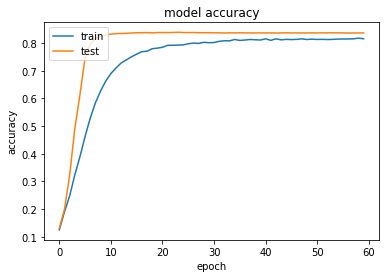

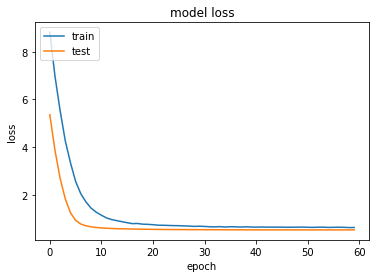

In [ ]:
import matplotlib.pyplot as plt
plt.plot(mm2_history.history['accuracy'])
plt.plot(mm2_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(mm2_history.history['loss'])
plt.plot(mm2_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()